# Parking Simulator
In this simulation we simulate a parking garage nearby a supermarket.
- https://www.centrumparkeren.nl/hilversum/parkeergarages/gooiland
- https://www.google.com/search?q=albert+heijn+gooialdn&oq=albert+heijn+gooialdn&aqs=chrome..69i57j0l2.13159j0j4&sourceid=chrome&ie=UTF-8


In [1]:
import simpy
import random

In [2]:
RANDOM_SEED = 42
SIM_TIME = 24 * 60

# The peak hours
PEAK_MIN = 15 * 60   # 15:00
PEAK_MAX = 20 * 60   # 20:00

# The maximum capacity of the garage
MAX_CAPACITY = 364

# Constants for the amount of time a car is parked
MIN_CAR_PARK_TIME = 1
MAX_CAR_PARK_TIME = 60

# constants for finding a spot
MIN_FINDING_SPOT = 1
MAX_FINDING_SPOT = 5

# constants for exiting the garage
MIN_EXITING_TIME = 1
MAX_EXITING_TIME = 3

In [3]:
def nrml_dist(min_, max_):
    """The function takes a minimal and maximal number and generates a number based on normal distribution"""
    mu = (max_ + min_) / 2
    sigma = mu / 3
    
    rd_numb = random.normalvariate(mu, sigma)
    
    if (rd_numb < min_):
        rd_numb = min_
    if (rd_numb > max_):
        rd_numb = max_
    
    return round(rd_numb)

# for i in range(50):
#     print(nrml_dist(MIN_FINDING_SPOT, MAX_FINDING_SPOT))

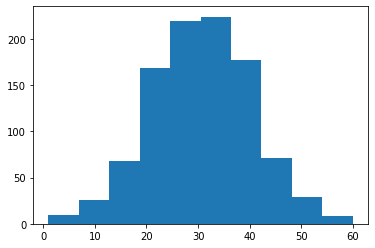

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
park_times = []

for i in range(1000):
    park_times.append(nrml_dist(MIN_CAR_PARK_TIME, MAX_CAR_PARK_TIME))

park_times.sort()
plt.hist(park_times)
plt.show()

In [5]:
class Garage(object):
    def __init__(self, env, max_spots=MAX_CAPACITY):
        self.env = env
        self.spots = simpy.Resource(env, max_spots)

In [6]:
def car(env, name, garage, data):
    """"""
    
    # Request one of its charging spots
    print('%s arriving at %d' % (name, env.now))
    with garage.spots.request() as req:
        yield req
        
        time_of_assignment = env.now
        
        # Find spot
        print('%s finding parking spot %s' % (name, env.now))
        yield env.timeout(nrml_dist(MIN_FINDING_SPOT, MAX_FINDING_SPOT))

        # Park car
        print('%s starting to park %s' % (name, env.now))
        yield env.timeout(nrml_dist(MIN_CAR_PARK_TIME, MAX_CAR_PARK_TIME))
        print('%s leaving the parking spot %s' % (name, env.now))
        
        # Leaving garage
        print('%s starting to leave %s' % (name, env.now))
        yield env.timeout(nrml_dist(MIN_EXITING_TIME, MAX_EXITING_TIME))
        time_of_departure = env.now

        print('%s left %s' % (name, time_of_departure))
        
        data.append((time_of_assignment, time_of_departure))
        

In [7]:
def new_cars_amount(is_peak):
    """"""
    
    total_cars = 0
    
    if is_peak:
        total_cars = 2
    else:
        total_cars = 1
        
    return total_cars

In [8]:
def setup(env, data):
    """"""
    garage = Garage(env)
    
    time_now = 0
    car_numb = 0
        
    while True:
        yield env.timeout(1)
        
        if (PEAK_MIN <= time_now <= PEAK_MAX):
            total_new_cars = new_cars_amount(True)
        else:
            total_new_cars = new_cars_amount(False)
        
        time_now += 1
        
        for i in range(total_new_cars):
            env.process(car(env, car_numb, garage, data))
            car_numb += 1

In [9]:
def main():
    """"""
    
    data = []
    
    random.seed(RANDOM_SEED)
    env = simpy.Environment()
    
    env.process(setup(env, data))
    
    env.run(until=SIM_TIME)
    
    print(data)

main()

0 arriving at 1
0 finding parking spot 1
1 arriving at 2
1 finding parking spot 2
2 arriving at 3
2 finding parking spot 3
0 starting to park 4
3 arriving at 4
3 finding parking spot 4
1 starting to park 5
4 arriving at 5
4 finding parking spot 5
3 starting to park 6
5 arriving at 6
5 finding parking spot 6
2 starting to park 7
4 starting to park 7
6 arriving at 7
6 finding parking spot 7
7 arriving at 8
7 finding parking spot 8
5 starting to park 9
8 arriving at 9
8 finding parking spot 9
9 arriving at 10
9 finding parking spot 10
10 arriving at 11
10 finding parking spot 11
6 starting to park 12
11 arriving at 12
11 finding parking spot 12
7 starting to park 13
8 starting to park 13
12 arriving at 13
12 finding parking spot 13
9 starting to park 14
10 starting to park 14
11 starting to park 14
13 arriving at 14
13 finding parking spot 14
14 arriving at 15
14 finding parking spot 15
12 starting to park 16
15 arriving at 16
15 finding parking spot 16
13 starting to park 17
16 arriving 

350 arriving at 351
350 finding parking spot 351
332 leaving the parking spot 352
332 starting to leave 352
347 starting to park 352
309 left 352
319 left 352
351 arriving at 352
351 finding parking spot 352
320 leaving the parking spot 353
320 starting to leave 353
329 left 353
352 arriving at 353
352 finding parking spot 353
312 leaving the parking spot 354
312 starting to leave 354
349 starting to park 354
350 starting to park 354
332 left 354
353 arriving at 354
353 finding parking spot 354
320 left 355
354 arriving at 355
354 finding parking spot 355
351 starting to park 356
352 starting to park 356
312 left 356
355 arriving at 356
354 starting to park 356
355 finding parking spot 356
305 leaving the parking spot 357
305 starting to leave 357
353 starting to park 357
356 arriving at 357
356 finding parking spot 357
305 left 358
357 arriving at 358
357 finding parking spot 358
355 starting to park 359
358 arriving at 359
358 finding parking spot 359
321 leaving the parking spot 360

643 left 678
677 arriving at 678
677 finding parking spot 678
674 starting to park 679
642 left 679
675 starting to park 679
678 arriving at 679
678 finding parking spot 679
655 leaving the parking spot 680
655 starting to leave 680
647 left 680
677 starting to park 680
679 arriving at 680
679 finding parking spot 680
678 starting to park 681
680 arriving at 681
680 finding parking spot 681
652 leaving the parking spot 682
652 starting to leave 682
676 starting to park 682
655 left 682
681 arriving at 682
681 finding parking spot 682
679 starting to park 683
682 arriving at 683
682 finding parking spot 683
665 leaving the parking spot 684
665 starting to leave 684
683 arriving at 684
683 finding parking spot 684
654 leaving the parking spot 685
654 starting to leave 685
652 left 685
684 arriving at 685
684 finding parking spot 685
649 leaving the parking spot 686
649 starting to leave 686
680 starting to park 686
681 starting to park 686
685 arriving at 686
685 finding parking spot 686

995 starting to park 952
914 left 952
924 left 952
997 starting to park 952
928 left 952
1002 arriving at 952
1003 arriving at 952
1002 finding parking spot 952
1003 finding parking spot 952
937 leaving the parking spot 953
937 starting to leave 953
945 leaving the parking spot 953
945 starting to leave 953
953 leaving the parking spot 953
953 starting to leave 953
998 starting to park 953
999 starting to park 953
917 left 953
941 left 953
947 left 953
1004 arriving at 953
1005 arriving at 953
1004 finding parking spot 953
1005 finding parking spot 953
922 leaving the parking spot 954
922 starting to leave 954
948 leaving the parking spot 954
948 starting to leave 954
964 leaving the parking spot 954
964 starting to leave 954
921 left 954
1000 starting to park 954
955 left 954
954 left 954
937 left 954
1006 arriving at 954
1007 arriving at 954
1006 finding parking spot 954
1007 finding parking spot 954
1003 starting to park 955
945 left 955
953 left 955
922 left 955
1008 arriving at 95

1347 finding parking spot 1124
1271 leaving the parking spot 1125
1271 starting to leave 1125
1295 leaving the parking spot 1125
1295 starting to leave 1125
1344 starting to park 1125
1348 arriving at 1125
1349 arriving at 1125
1348 finding parking spot 1125
1349 finding parking spot 1125
1279 leaving the parking spot 1126
1279 starting to leave 1126
1343 starting to park 1126
1345 starting to park 1126
1347 starting to park 1126
1271 left 1126
1350 arriving at 1126
1351 arriving at 1126
1350 finding parking spot 1126
1351 finding parking spot 1126
1257 leaving the parking spot 1127
1257 starting to leave 1127
1259 leaving the parking spot 1127
1259 starting to leave 1127
1290 leaving the parking spot 1127
1290 starting to leave 1127
1300 leaving the parking spot 1127
1300 starting to leave 1127
1346 starting to park 1127
1295 left 1127
1279 left 1127
1352 arriving at 1127
1353 arriving at 1127
1352 finding parking spot 1127
1353 finding parking spot 1127
1280 leaving the parking spot 

1511 starting to leave 1250
1530 leaving the parking spot 1250
1530 starting to leave 1250
1547 starting to park 1250
1521 left 1250
1524 left 1250
1548 starting to park 1250
1550 arriving at 1250
1550 finding parking spot 1250
1523 leaving the parking spot 1251
1523 starting to leave 1251
1504 left 1251
1551 arriving at 1251
1551 finding parking spot 1251
1509 leaving the parking spot 1252
1509 starting to leave 1252
1530 left 1252
1552 arriving at 1252
1552 finding parking spot 1252
1549 starting to park 1253
1511 left 1253
1523 left 1253
1553 arriving at 1253
1553 finding parking spot 1253
1548 leaving the parking spot 1254
1548 starting to leave 1254
1550 starting to park 1254
1551 starting to park 1254
1552 starting to park 1254
1554 arriving at 1254
1554 finding parking spot 1254
1509 left 1255
1553 starting to park 1255
1548 left 1255
1555 arriving at 1255
1555 finding parking spot 1255
1556 arriving at 1256
1556 finding parking spot 1256
1514 leaving the parking spot 1257
1514 